In [ ]:
!pip install PyTDC

In [ ]:
!pip install rdkit

In [58]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GroupShuffleSplit

from tdc.multi_pred import DrugRes

In [65]:
# Load the GDSC dataset from TDC
data = DrugRes(name = 'gdsc1')

# Get the entire dataset as a pandas dataframe
gdsc1_df = data.get_data()

# Display the dataframe to see its structure
gdsc1_df.head()

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Cell Line_ID,Cell Line,Y
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,MC-CAR,"[3.23827250519154, 2.98225419469807, 10.235490...",2.395685
1,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES3,"[8.690197905033282, 3.0914731119366, 9.9924871...",3.140923
2,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES5,"[8.233101127037282, 2.82468731112752, 10.01588...",3.968757
3,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES7,"[8.33346622426757, 3.9667571228514302, 9.79399...",2.692768
4,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,EW-11,"[8.39134072442845, 2.9683601858810698, 10.2606...",2.478678


In [4]:
# Get the gene symbols
gene_labels = data.get_gene_symbols()
print(f"Total number of genes: {len(gene_labels)}")
print(f"\nFirst 20 gene symbols:")
print(gene_labels[:20])

Downloading...
100%|██████████| 149k/149k [00:00<00:00, 860kiB/s] 
Loading...


Total number of genes: 17737

First 20 gene symbols:
['TSPAN6' 'TNMD' 'DPM1' 'SCYL3' 'C1orf112' 'FGR' 'CFH' 'FUCA2' 'GCLC'
 'NFYA' 'STPG1' 'NIPAL3' 'LAS1L' 'ENPP4' 'SEMA3F' 'CFTR' 'ANKIB1' 'KRIT1'
 'RAD52' 'BAD']


In [5]:
type(gene_labels)

numpy.ndarray

In [11]:
gene_expression_df = pd.DataFrame(
    gdsc1_df['Cell Line'].to_list(),
    columns=gene_labels,
    dtype=np.float32
)

In [12]:
gene_expression_df.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00526,PPY2,NaN,NaN,KRT18P55,NaN,POLRMTP1,UBL5P2,TBC1D3P5,NaN
0,3.238272,2.982254,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,5.042464,5.438402,...,5.866047,3.095716,3.502513,8.564318,3.274367,4.018073,3.056214,9.446305,3.530871,6.134269
1,8.690198,3.091473,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,5.446361,5.348338,...,5.097089,3.114744,3.120520,8.591651,3.119647,2.588673,3.194925,9.013220,3.074187,8.173054
2,8.233101,2.824687,10.015883,4.749715,3.839433,3.142755,5.329830,3.272124,5.538055,6.428482,...,6.261573,3.031862,3.370459,8.930821,3.322455,3.083922,2.813440,8.893197,3.266184,8.758288
3,8.333467,3.966757,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,5.794734,5.902391,...,3.885425,2.993918,2.843472,8.246666,3.219777,3.683564,3.033869,8.691401,3.279230,8.236238
4,8.391340,2.968360,10.260679,4.295876,4.129471,3.318760,7.103957,3.447994,5.988207,6.257495,...,5.584552,2.959515,2.952987,8.625519,3.056066,3.059551,3.127004,9.396461,3.217885,7.248236


In [53]:
gene_expression_df.shape

(177310, 17737)

In [34]:
# Extract the metadata columns plus the Drug column from the original gdsc1_df dataframe
gdsc1_meta_df = gdsc1_df[['Drug_ID', 'Drug', 'Cell Line_ID', 'Y']]

# Concatenate with the new gene_expression_df
gdsc1_processed_df = pd.concat([gdsc1_meta_df, gene_expression_df], axis=1)

print(f"Shape of the gdsc1_processed_df dataframe: {gdsc1_processed_df.shape}")
gdsc1_processed_df.head()

Shape of the gdsc1_processed_df dataframe: (177310, 17741)


,Drug_ID,Drug,Cell Line_ID,Y,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,...,LINC00526,PPY2,NaN,NaN,KRT18P55,NaN,POLRMTP1,UBL5P2,TBC1D3P5,NaN
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,MC-CAR,2.395685,3.238272,2.982254,10.235491,4.856061,4.078870,9.116236,...,5.866047,3.095716,3.502513,8.564318,3.274367,4.018073,3.056214,9.446305,3.530871,6.134269
1,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES3,3.140923,8.690198,3.091473,9.992487,4.572198,3.333385,3.320793,...,5.097089,3.114744,3.120520,8.591651,3.119647,2.588673,3.194925,9.013220,3.074187,8.173054
2,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES5,3.968757,8.233101,2.824687,10.015883,4.749715,3.839433,3.142755,...,6.261573,3.031862,3.370459,8.930821,3.322455,3.083922,2.813440,8.893197,3.266184,8.758288
3,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES7,2.692768,8.333467,3.966757,9.793991,3.976923,3.505669,3.079943,...,3.885425,2.993918,2.843472,8.246666,3.219777,3.683564,3.033869,8.691401,3.279230,8.236238
4,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,EW-11,2.478678,8.391340,2.968360,10.260679,4.295876,4.129471,3.318760,...,5.584552,2.959515,2.952987,8.625519,3.056066,3.059551,3.127004,9.396461,3.217885,7.248236


In [35]:
gdsc1_processed_df['Y'].describe()

,Y
count,177310.000000
mean,2.007088
std,2.714737
min,-9.933406
25%,0.587560
50%,2.459601
75%,3.908216
max,12.359056


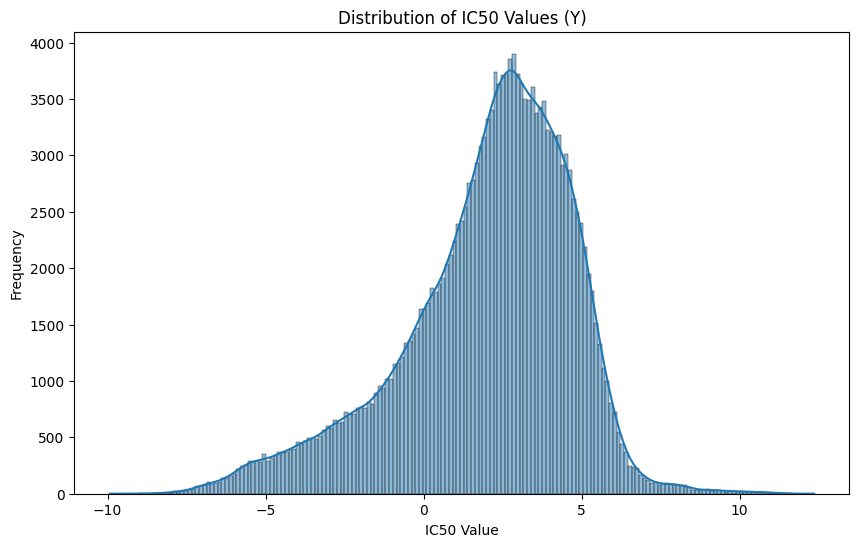

In [36]:
# Histogram of the 'Y' variable
plt.figure(figsize=(10, 6))
sns.histplot(gdsc1_processed_df['Y'], kde=True)
plt.title('Distribution of IC50 Values (Y)')
plt.xlabel('IC50 Value')
plt.ylabel('Frequency')
plt.show()

In [37]:
gdsc1_processed_df['Drug_ID'].nunique()

208

In [38]:
gdsc1_processed_df['Drug_ID'].value_counts().max()

1837

In [39]:
gdsc1_processed_df['Drug_ID'].value_counts().min()

372

In [40]:
gdsc1_processed_df['Drug_ID'].value_counts().head(20)

,count
Drug_ID,
PLX-4720,1837
Afatinib,1824
Avagacestat,1823
Olaparib,1819
UNC0638,1803
Pictilisib,1786
Selumetinib,1781
Refametinib,1772
AZD6482,1762


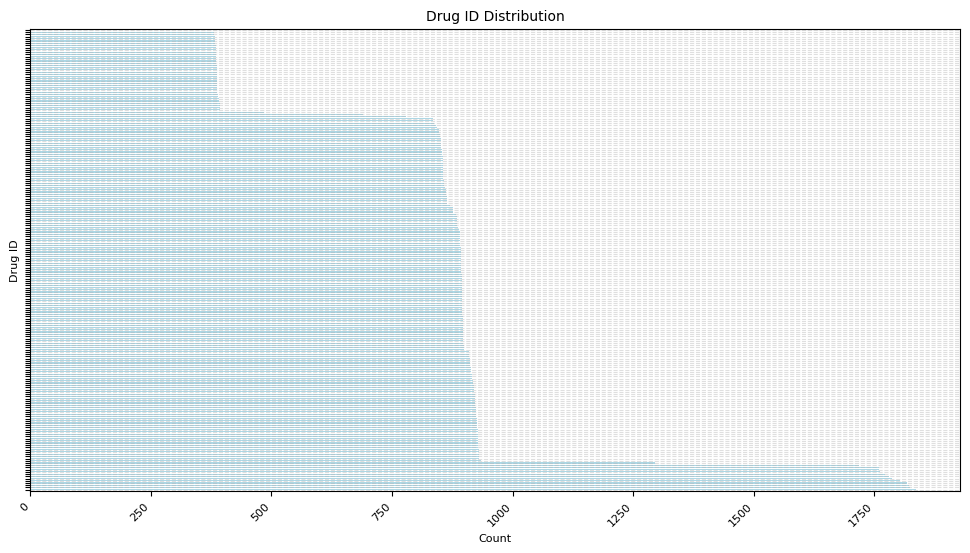

In [41]:
drug_ID_counts = gdsc1_processed_df['Drug_ID'].value_counts()

plt.figure(figsize=(12, 6))
drug_ID_counts.plot(kind="barh", color='lightblue')
plt.xlabel("Count", fontsize=8)
plt.ylabel("Drug ID", fontsize=8)
plt.title("Drug ID Distribution", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.tick_params(axis='y', labelleft=False) # Hide y-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

In [42]:
gdsc1_processed_df['Cell Line_ID'].nunique()

958

In [43]:
gdsc1_processed_df['Cell Line_ID'].value_counts().max()

221

In [44]:
gdsc1_processed_df['Cell Line_ID'].value_counts().min()

1

In [45]:
gdsc1_processed_df['Cell Line_ID'].value_counts().head(50)

,count
Cell Line_ID,
TE-12,221
EW-1,221
LAN-6,221
EW-16,221
SNB75,221
NCI-H1436,221
NCI-H1155,221
OS-RC-2,221
COLO-684,221


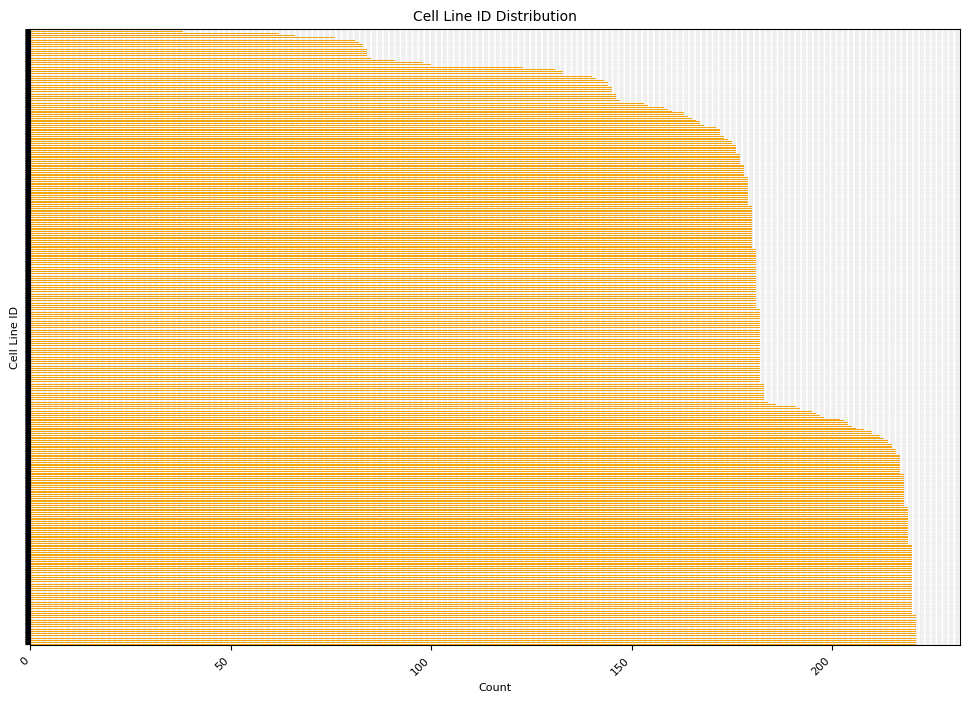

In [46]:
cell_line_counts = gdsc1_processed_df['Cell Line_ID'].value_counts()

plt.figure(figsize=(12, 8))
cell_line_counts.plot(kind="barh", color='orange')
plt.xlabel("Count", fontsize=8)
plt.ylabel("Cell Line ID", fontsize=8)
plt.title("Cell Line ID Distribution", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.tick_params(axis='y', labelleft=False) # Hide y-axis labels
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [47]:
gdsc1_processed_df.isnull().sum().sum()

0

In [66]:
# Calculate the variance of each gene expression column
gene_expression_variance = gene_expression_df.var()

print("Variance of gene expression for first five genes:")
print(gene_expression_variance.head())

# Sort the variances to see which genes have the highest/lowest variance
print("\nTop 10 genes with highest variance:")
print(gene_expression_variance.sort_values(ascending=False).head(10))

print("\nTop 10 genes with lowest variance:")
print(gene_expression_variance.sort_values(ascending=True).head(10))

Variance of gene expression for first five genes:
TSPAN6      3.662867
TNMD        0.044250
DPM1        0.303579
SCYL3       0.281605
C1orf112    0.179087
dtype: float32

Top 10 genes with highest variance:
RPS4Y1     15.797991
KRT19      15.387221
VIM        13.534711
S100P      13.134761
TACSTD2    12.856094
TGFBI      12.287282
nan        12.262770
TM4SF1     12.058323
CAV1       11.791290
SRGN       11.769511
dtype: float32

Top 10 genes with lowest variance:
ECT2L      0.006489
GLRA3      0.006848
PCDH15     0.007026
ANKUB1     0.007276
C4orf40    0.007569
DEFB121    0.007648
C2orf73    0.007759
NME9       0.007880
MOBP       0.007926
OPRM1      0.008042
dtype: float32


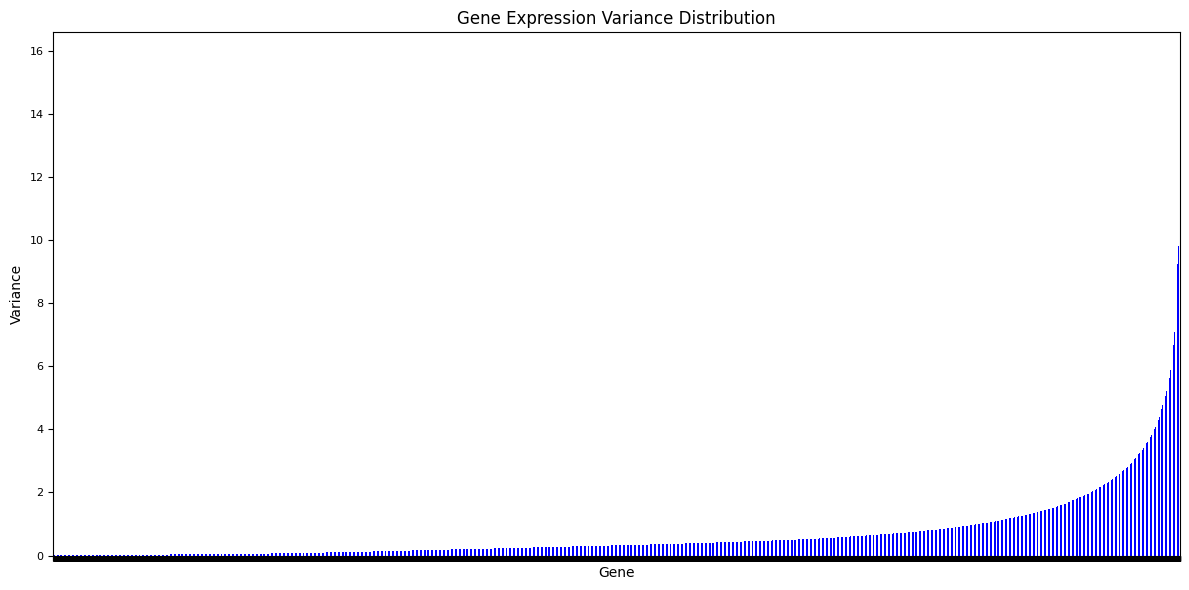

In [49]:
plt.figure(figsize=(12, 6))
gene_expression_variance.sort_values().plot(kind="bar", color='blue')
plt.xlabel("Gene", fontsize=10)
plt.ylabel("Variance", fontsize=10)
plt.title("Gene Expression Variance Distribution", fontsize=12)
plt.tick_params(axis='x', labelbottom=False) # Hide x-axis labels (gene names)
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

In [60]:
# Define a variance threshold
threshold = 0.1

selector = VarianceThreshold(threshold=threshold)

# Convert column names to strings
gene_expression_df.columns = gene_expression_df.columns.astype(str)

# Fit and transform the gene expression data
gene_expression_thresholded = selector.fit_transform(gene_expression_df)

# Get the names of the selected genes
selected_genes = gene_expression_df.columns[selector.get_support()]

# Create a new dataframe with the selected genes
gene_expression_df_filtered = pd.DataFrame(gene_expression_thresholded, columns=selected_genes, index=gene_expression_df.index)

print(f"Original number of genes: {gene_expression_df.shape[1]}")
print(f"Number of genes after variance thresholding (threshold={threshold}): {gene_expression_df_filtered.shape[1]}")

gene_expression_df_filtered.head()

Original number of genes: 17737
Number of genes after variance thresholding (threshold=0.1): 13391


,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,OR1D5,ZNF234,nan,MYH4,LINC00526,nan,nan,nan,UBL5P2,nan
0,3.238272,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,5.042464,5.438402,3.336360,...,3.724013,3.981948,3.904874,2.823245,5.866047,3.502513,8.564318,4.018073,9.446305,6.134269
1,8.690198,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,5.446361,5.348338,3.291030,...,2.929492,4.702209,4.186925,2.489674,5.097089,3.120520,8.591651,2.588673,9.013220,8.173054
2,8.233101,10.015883,4.749715,3.839433,3.142755,5.329830,3.272124,5.538055,6.428482,2.980635,...,3.226083,4.666296,5.399840,2.491254,6.261573,3.370459,8.930821,3.083922,8.893197,8.758288
3,8.333467,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,5.794734,5.902391,3.301069,...,3.738082,4.705392,3.594570,2.667881,3.885425,2.843472,8.246666,3.683564,8.691401,8.236238
4,8.391340,10.260679,4.295876,4.129471,3.318760,7.103957,3.447994,5.988207,6.257495,3.607291,...,3.522861,4.500115,3.958256,2.600511,5.584552,2.952987,8.625519,3.059551,9.396461,7.248236


In [67]:
# Retrieve unique drug IDs and their SMILES strings
drug_smiles_df = gdsc1_processed_df[['Drug_ID', 'Drug']].drop_duplicates().reset_index(drop=True)

print(f"\nNumber of unique drugs: {drug_smiles_df.shape[0]}")

drug_smiles_df.head()


Number of unique drugs: 208


,Drug_ID,Drug
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...
1,Sunitinib,CCN(CC)CCNC(=O)C1=C(NC(=C1C)/C=C\2/C3=C(C=CC(=...
2,PHA-665752,CC1=C(NC(=C1C(=O)N2CCC[C@@H]2CN3CCCC3)C)/C=C\4...
3,MG-132,CC(C)C[C@@H](C=O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H...
4,Paclitaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...


In [68]:
# Function to generate chemical fingerprints
def generate_fingerprint(smiles, radius=2, nbits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits))
    return np.array([0] * nbits) # Return a zero vector for invalid SMILES

# Apply the function to the drug_smiles_df
fingerprint_matrix = np.vstack(drug_smiles_df['Drug'].apply(generate_fingerprint))

# Create a a new dataframe from the fingerprints_matrix
fingerprint_df = pd.DataFrame(fingerprint_matrix, columns=[f'FP_{i}' for i in range(fingerprint_matrix.shape[1])])

# Add the Drug_ID back to the fingerprint_df for merging
fingerprint_df['Drug_ID'] = drug_smiles_df['Drug_ID']

print(f"\nShape of the fingerprint DataFrame: {fingerprint_df.shape}")

fingerprint_df.head()


Shape of the fingerprint DataFrame: (208, 2049)


,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047,Drug_ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Erlotinib
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Sunitinib
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,PHA-665752
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,MG-132
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Paclitaxel


In [69]:
# Merge gene_expression_df_filtered with fingerprint_df based on Drug_ID
gdsc1_merged_df = pd.merge(
    gdsc1_processed_df[['Drug_ID', 'Cell Line_ID', 'Y']], # Include metadata needed for split
    gene_expression_df_filtered,
    left_index=True,
    right_index=True # Merge on index as both come from the same original rows
)

gdsc1_merged_df = pd.merge(
    gdsc1_merged_df,
    fingerprint_df,
    on='Drug_ID',
    how='left'
)

print(f"\nShape of the gdsc1_merged_df: {gdsc1_merged_df.shape}")

gdsc1_merged_df.head()


Shape of the gdsc1_merged_df: (177310, 15442)


,Drug_ID,Cell Line_ID,Y,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,Erlotinib,MC-CAR,2.395685,3.238272,10.235491,4.856061,4.078870,9.116236,3.658590,6.145475,...,0,0,0,0,0,0,0,0,0,0
1,Erlotinib,ES3,3.140923,8.690198,9.992487,4.572198,3.333385,3.320793,3.159487,3.515105,...,0,0,0,0,0,0,0,0,0,0
2,Erlotinib,ES5,3.968757,8.233101,10.015883,4.749715,3.839433,3.142755,5.329830,3.272124,...,0,0,0,0,0,0,0,0,0,0
3,Erlotinib,ES7,2.692768,8.333467,9.793991,3.976923,3.505669,3.079943,3.373640,4.199048,...,0,0,0,0,0,0,0,0,0,0
4,Erlotinib,EW-11,2.478678,8.391340,10.260679,4.295876,4.129471,3.318760,7.103957,3.447994,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# Define the features (X) and the target (y)

# Define X from the merged dataframe, excluding metadata and target
X = gdsc1_merged_df.drop(columns=['Drug_ID', 'Cell Line_ID', 'Y'])
y = gdsc1_merged_df['Y']
groups = gdsc1_merged_df['Drug_ID']

# Initialize the GroupShuffleSplit for train/test split
# n_splits=1 means we get one pair of train/test sets.
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# The .split() method returns the indices for the train and test sets
train_idx, test_idx = next(gss.split(X, y, groups))

# Create the train and test sets using the indices
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Verify the split
train_drugs = set(gdsc1_merged_df.iloc[train_idx]['Drug_ID'])
test_drugs = set(gdsc1_merged_df.iloc[test_idx]['Drug_ID'])
common_drugs = train_drugs.intersection(test_drugs)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nNumber of drugs in training set: {len(train_drugs)}")
print(f"Number of drugs in testing set: {len(test_drugs)}")
print(f"Number of drugs common to both sets: {len(common_drugs)}")

X_train shape: (138279, 15439)
y_train shape: (138279,)
X_test shape: (39031, 15439)
y_test shape: (39031,)

Number of drugs in training set: 166
Number of drugs in testing set: 42
Number of drugs common to both sets: 0
